In [1]:
# Connecting to Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Installing libraries
!pip install sentencepiece
!pip install transformers datasets
!pip install torch huggingface_hub
!pip install rouge.score nltk py7zr
!pip install transformers[torch]
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 14.8 MB/s eta 0:00

In [3]:
# Importing the required libraries
import torch
import numpy as np
import pandas as pd
import datasets
import transformers
import nltk

# 'punkt' is a pre-trained tokenizer for tokenizing text into words or sentences
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
# Specifying parameters


LR = 3e-5  # Learning rate for optimization
WD = 2e-5  # Weight decay for regularization
WD_CEIL = 0.01  # Ceiling value for weight decay
NUM_TRIALS = 1  # Number of trials for experimentation
WARMUP_RATIO = 0.05  # Warmup ratio for learning rate scheduling
SAVE_DIR = 'optimal-test'  # Directory to save optimization results
MODEL_NAME = 't5-base'  # Name of the pre-trained model used
MAX_INPUT = 512  # Maximum number of tokens for input sequence
MAX_TARGET = 250  # Maximum number of tokens for target sequence


# Selecting the first 1000 rows from the dataset
dataset_path = 'gdrive/My Drive/fyp/'
data = pd.read_csv(dataset_path + 'researchpapers.csv', encoding='latin-1')
data = data[0:1000]

# Loading the Rouge metric for evaluation
metric = datasets.load_metric('rouge')
data

# Defining a custom print function for better readability
def print_custom(text):
    print('\n')
    print(text)
    print('-'*100)

<ipython-input-4-9ef9adb92e87>:21: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric('rouge')
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [5]:
# Loading the tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [6]:
# Preprocessing data
prefix = "Summarize: "
def preprocess_data(data_to_process):

    # Retrieve document texts from the 'full_text' column of the provided dataset
    inputs = [prefix + doc for doc in data_to_process["full_text"]]

    #tokenize text from the document
    model_inputs = tokenizer(inputs,  max_length=MAX_INPUT, padding='max_length', truncation=True)

    # Tokenize the target labels "abstract texts"
    with tokenizer.as_target_tokenizer():
        targets = tokenizer(data_to_process['abstract_text'], max_length=MAX_TARGET, padding='max_length', truncation=True)

    # Assigning the tokenized labels "input_ids" to the 'labels' key in model_inputs
    model_inputs['labels'] = targets['input_ids']

    return model_inputs

In [7]:
# Perform a train,test and validation split of 80:20 ratio on the dataset
train_dataset = data[:int(len(data)*0.7)]
test_dataset = data[int(len(data)*0.7):int(len(data)*0.85)]
validation_dataset = data[int(len(data)*0.85):]

# Creating the dataset dictionary containing the train, test, and validation datasets
data = datasets.DatasetDict({ 'train': datasets.Dataset.from_pandas(train_dataset),
                              'test': datasets.Dataset.from_pandas(test_dataset),
                              'validation': datasets.Dataset.from_pandas(train_dataset)})

In [8]:
# Preprocessing data
tokenize_data = data.map(preprocess_data, batched = True, remove_columns=['full_text', 'abstract_text'])

Map:   0%|          | 0/431 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/93 [00:00<?, ? examples/s]

Map:   0%|          | 0/431 [00:00<?, ? examples/s]

In [9]:
#sample the data into subsets
train_sample = tokenize_data['train'].shuffle(seed=123).select(range(400))
validation_sample = tokenize_data['validation'].shuffle(seed=123).select(range(300))
test_sample = tokenize_data['test'].shuffle(seed=123).select(range(90))

# Updating tokenize_data dictionary with the sampled datasets
tokenize_data['train'] = train_sample
tokenize_data['validation'] = validation_sample
tokenize_data['test'] = test_sample

tokenize_data

DatasetDict({
    train: Dataset({
        features: ['article_id', 'article_name', 'tokens', 'link', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 400
    })
    test: Dataset({
        features: ['article_id', 'article_name', 'tokens', 'link', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 90
    })
    validation: Dataset({
        features: ['article_id', 'article_name', 'tokens', 'link', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 300
    })
})

In [10]:
# Setting the batch size to 1 , processing one example at a time to maintain sequential dependencies
batch_size = 1

# Function to compute ROUGE scores and additional metrics for generated summaries
def compute_rouge(pred):
    predictions, labels = pred

    # Decode the predictions and labels into readable text, skipping special tokens
    decode_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decode_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute ROUGE scores using the metric object, comparing predictions against labels
    res = metric.compute(predictions=decode_predictions, references=decode_labels, use_stemmer=True)

    # Extract the ROUGE scores and multiply by 100 for better readability
    res = {key: value.mid.fmeasure * 100 for key, value in res.items()}

    # Define weights for each ROUGE score to compute the weighted average
    weights = {'rouge1': 0.5, 'rouge2': 0.3, 'rougeL': 0.2}

    # Compute the weighted average of the ROUGE scores
    weighted_avg_rouge = sum(res[key] * weight for key, weight in weights.items()) / sum(weights.values())

    # Add the weighted average ROUGE score to the results dictionary
    res['weighted_avg_rouge'] = round(weighted_avg_rouge, 4)

    # Compute the average length of generated summaries
    # Count the number of non-padding tokens in each prediction and take the mean
    pred_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    res['avg_gen_len'] = np.mean(pred_lens)

    # Round all values in the results dictionary to four decimal places
    return {k: round(v, 4) for k, v in res.items()}



In [11]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import MultiheadAttention

# Defining a custom PyTorch module for hierarchical attention
class HierarchicalAttention(nn.Module):
    def __init__(self, hidden_size, num_heads=8):
        super(HierarchicalAttention, self).__init__()
        # Initializing word-level attention mechanism
        self.word_attention = MultiheadAttention(hidden_size, num_heads)
        # Initializing sentence-level attention mechanism
        self.sentence_attention = MultiheadAttention(hidden_size, num_heads)

    def forward(self, input_embeds):
        # Compute word-level attention scores
        word_level_output, _ = self.word_attention(input_embeds, input_embeds, input_embeds)

        # Compute sentence-level attention scores
        sentence_level_output, _ = self.sentence_attention(word_level_output, word_level_output, word_level_output)

        # Return the aggregated representation at the sentence level
        return sentence_level_output

In [13]:
# Modifying the model architecture

class HierarchicalT5(AutoModelForSeq2SeqLM):
    def __init__(self, config):
        super().__init__(config)
        self.hierarchical_attention = HierarchicalAttention(config.d_model)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        head_mask=None,
        decoder_head_mask=None,
        cross_attn_head_mask=None,
        past_key_values=None,
        inputs_embeds=None,
        decoder_inputs_embeds=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        # Convert input_ids to input embeddings
        if input_ids is not None and inputs_embeds is None:
          inputs_embeds = self.embed_tokens(input_ids)

        # Apply the hierarchical attention to the input embeddings
        inputs_embeds = self.hierarchical_attention(inputs_embeds)

        # Apply the T5 model with the modified input
        return super().forward(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            head_mask=head_mask,
            decoder_head_mask=decoder_head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            decoder_inputs_embeds=decoder_inputs_embeds,
            labels=labels,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

In [14]:
# Instantiate the modified model
hierarchical_model = HierarchicalT5.from_pretrained(MODEL_NAME)

# Data_collator to create batches
data_collator = transformers.DataCollatorForSeq2Seq(tokenizer, model=hierarchical_model)

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [15]:
# Creating training arguments to train the model
args = transformers.Seq2SeqTrainingArguments(
    'abstract-summary',
    evaluation_strategy='epoch',
    learning_rate=0.001,
    per_device_train_batch_size=1,
    per_device_eval_batch_size= 1,
    gradient_accumulation_steps=2,
    weight_decay=0.1,
    save_total_limit=2,
    warmup_ratio=0.02,
    num_train_epochs=5,
    predict_with_generate=True,
    eval_accumulation_steps=1,
    fp16=True
  )


# Create the trainer to train the model
trainer = transformers.Seq2SeqTrainer(
    hierarchical_model,
    args,
    train_dataset=tokenize_data['train'],
    eval_dataset=tokenize_data['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_rouge
)

In [16]:
# Clearing the cuda memory
import torch
torch.cuda.empty_cache()

In [17]:
# Train the model
trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Weighted Avg Rouge,Avg Gen Len
1,No log,0.056544,18.374900,17.142900,18.380900,18.365200,18.006500,19.000000
2,No log,0.059400,18.347800,17.065700,18.349000,18.335500,17.963400,19.000000
3,0.381700,0.042904,18.373600,17.111300,18.369500,18.357000,17.994100,19.000000
4,0.381700,0.039344,18.368800,17.112100,18.373100,18.365600,17.992600,19.000000
5,0.133300,0.038286,18.389700,17.129400,18.385900,18.378800,18.010800,19.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


TrainOutput(global_step=1000, training_loss=0.2575180358886719, metrics={'train_runtime': 1141.9856, 'train_samples_per_second': 1.751, 'train_steps_per_second': 0.876, 'total_flos': 1217915781120000.0, 'train_loss': 0.2575180358886719, 'epoch': 5.0})

In [18]:
# Clearing the cuda memory
torch.cuda.empty_cache()

In [19]:
# Evaluate the model
metrics = trainer.evaluate()

In [20]:
# Print the metrics
print_custom('Printing the metrics')
print(metrics)

df = pd.DataFrame(trainer.state.log_history)



Printing the metrics
----------------------------------------------------------------------------------------------------
{'eval_loss': 0.03828594833612442, 'eval_rouge1': 18.3897, 'eval_rouge2': 17.1294, 'eval_rougeL': 18.3859, 'eval_rougeLsum': 18.3788, 'eval_weighted_avg_rouge': 18.0108, 'eval_avg_gen_len': 19.0, 'eval_runtime': 159.537, 'eval_samples_per_second': 1.88, 'eval_steps_per_second': 1.88, 'epoch': 5.0}


<Axes: title={'center': 'Evolution of ROUGE Scores and Weighted Average ROUGE by Epoch'}, xlabel='epoch'>

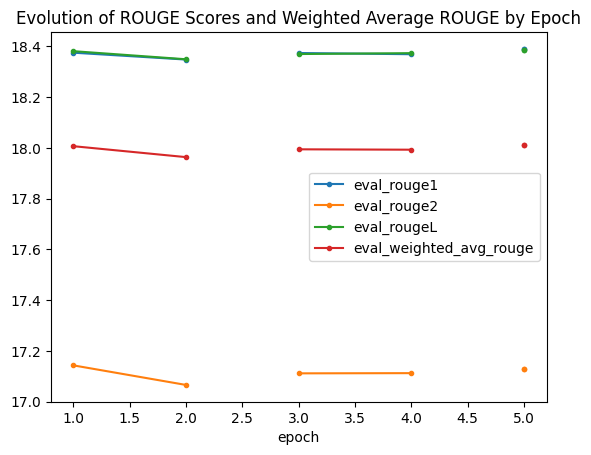

In [21]:
# Plotting the evolution of ROUGE Scores and Weighted Average ROUGE by Epoch
df.plot(x='epoch', y=['eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_weighted_avg_rouge'], style='.-', title="Evolution of ROUGE Scores and Weighted Average ROUGE by Epoch")

<Axes: title={'center': 'Comparison of Training and Evaluation Losses by Epoch'}, xlabel='epoch'>

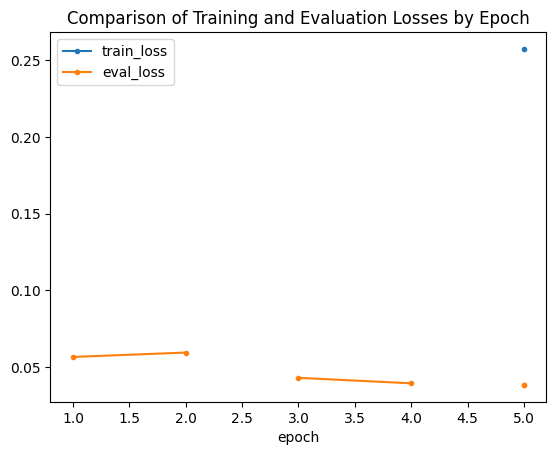

In [22]:
# Plotting the comparison of Training and Evaluation Losses by Epoch
df.plot(x='epoch', y=['train_loss', 'eval_loss'], style='.-', title="Comparison of Training and Evaluation Losses by Epoch")

In [26]:
import os
import re

def capitalize_sentences(summary):
    # Capitalize the first letter of each sentence
    summary = re.sub(r'(?<=\.\s)(\w)', lambda x: x.group(1).upper(), summary)

    # Remove any leading punctuation or whitespace
    summary = re.sub(r'^[^a-zA-Z]*', '', summary)

    # Ensure the first character is uppercase
    summary = summary[0].upper() + summary[1:]

    return summary

# The document to be summarized
document = """The task of summarization can be categorized into two methods, extractive and abstractive.
Extractive summarization selects the salient sentences from the original document to form a summary
while abstractive summarization interprets the original document and generates the summary in
its own words. The task of generating a summary, whether extractive or abstractive, has been
studied with different approaches in the literature, including statistical-, graph-, and deep learningbased
approaches. Deep learning has achieved promising performances in comparison to the
classical approaches, and with the advancement of different neural architectures such as the attention
network (commonly known as the transformer), there are potential areas of improvement for the
summarization task. The introduction of transformer architecture and its encoder model “BERT”
produced an improved performance in downstream tasks in NLP. BERT is a bidirectional encoder
representation from a transformer modeled as a stack of encoders. There are different sizes for
BERT, such as BERT-base with 12 encoders and BERT-larger with 24 encoders, but we focus on the
BERT-base for the purpose of this study. The objective of this paper is to produce a study on the
performance of variants of BERT-based models on text summarization through a series of experiments,
and propose “SqueezeBERTSum”, a trained summarization model fine-tuned with the SqueezeBERT
encoder variant, which achieved competitive ROUGE scores retaining the BERTSum baseline model
performance by 98%, with 49% fewer trainable parameters."""

# Encode the document using the tokenizer
inputs = tokenizer.encode(document, return_tensors='pt', max_length=MAX_INPUT, truncation=True)

# Ensure both model and inputs are on the same device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
hierarchical_model.to(device)
inputs = inputs.to(device)

# Generate a summary using the hierarchical model
outputs = hierarchical_model.generate(inputs, max_length=500, min_length=80, length_penalty=1.5, num_beams=5, early_stopping=True, no_repeat_ngram_size=2)
summary = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Use the capitalize_sentences function to refine the final summary
summary = capitalize_sentences(summary)

print("Generated-Summary:")
print(summary)


Generated-Summary:
Creating a summary, whether extractive or abstractive, has been studied with different approaches in the literature, including statistical-, graph- and deep learningbased approaches. Deep learning has achieved promising performances in comparison to the classical approaches, and with the advancement of different neural architectures such as the attention network (commonly known as  the transformer), there are potential areas of improvement for the summarization task. The introduction of transformer architecture and its encoder model “BERT” produced an improved performance in downstream tasks in NLP. BERT is


In [24]:
# Save the model
drive_path_to_save_model = 'gdrive/My Drive/prototype/SummarizationModels/' + MODEL_NAME + '-model'

# Ensure the model directory exists, and create it if not
model_directory = os.path.dirname(drive_path_to_save_model)
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# Save the model
hierarchical_model.save_pretrained(drive_path_to_save_model)

# Save the tokenizer
drive_path_to_save_tokenizer = 'gdrive/My Drive/prototype/SummarizationModels/' + MODEL_NAME + '-tokenizer'

# Ensure the tokenizer directory exists, and create it if not
tokenizer_directory = os.path.dirname(drive_path_to_save_tokenizer)
if not os.path.exists(tokenizer_directory):
    os.makedirs(tokenizer_directory)

# Save the tokenizer
tokenizer.save_pretrained(drive_path_to_save_tokenizer)

# Load the model
drive_path_to_load_model = 'gdrive/My Drive/prototype/SummarizationModels/' + MODEL_NAME + '-model'
loaded_model = transformers.AutoModelForSeq2SeqLM.from_pretrained(drive_path_to_load_model)

# Load the tokenizer
drive_path_to_load_tokenizer = 'gdrive/My Drive/prototype/SummarizationModels/' + MODEL_NAME + '-tokenizer'
loaded_tokenizer = transformers.AutoTokenizer.from_pretrained(drive_path_to_load_tokenizer)